In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_paths=[]
data_labels=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('_')[0][::-1]
        data_labels.append(label.lower())

df = pd.DataFrame({'speech':data_paths,'label':data_labels})
df.sample(10)

,speech,label
2424,/kaggle/input/toronto-emotional-speech-set-tes...,sad.wav
3949,/kaggle/input/toronto-emotional-speech-set-tes...,angry.wav
1577,/kaggle/input/toronto-emotional-speech-set-tes...,disgust.wav
2095,/kaggle/input/toronto-emotional-speech-set-tes...,happy.wav
104,/kaggle/input/toronto-emotional-speech-set-tes...,fear.wav
1418,/kaggle/input/toronto-emotional-speech-set-tes...,disgust.wav
619,/kaggle/input/toronto-emotional-speech-set-tes...,disgust.wav
786,/kaggle/input/toronto-emotional-speech-set-tes...,disgust.wav
827,/kaggle/input/toronto-emotional-speech-set-tes...,neutral.wav
3573,/kaggle/input/toronto-emotional-speech-set-tes...,disgust.wav


In [3]:
df.groupby('label').size()

label
angry.wav      800
disgust.wav    800
fear.wav       800
happy.wav      800
neutral.wav    800
ps.wav         800
sad.wav        800
dtype: int64

In [4]:
print(len(df['label'].unique()))

7


In [5]:
def plot_waveform(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [6]:
def plot_spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


In [7]:
def analyze_emotion(emotion: str, df: pd.DataFrame):
    path = df.loc[df['label'] == emotion, 'speech'].values[0]
    data, sampling_rate = librosa.load(path)
    
    plot_waveform(data, sampling_rate, emotion)
    plot_spectrogram(data, sampling_rate, emotion)
    
    display(Audio(path))


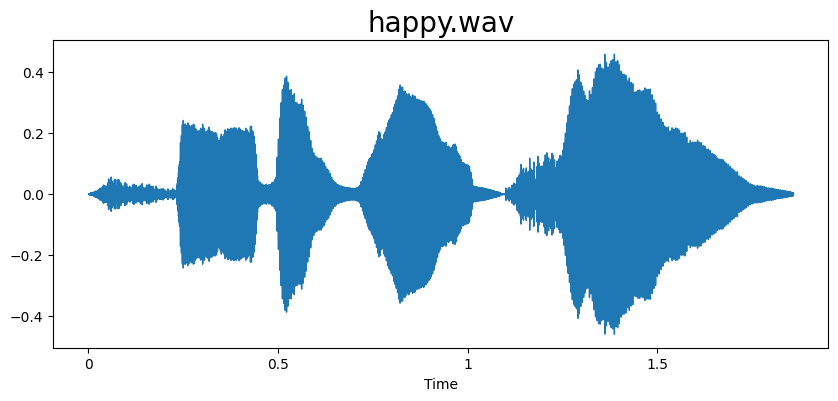

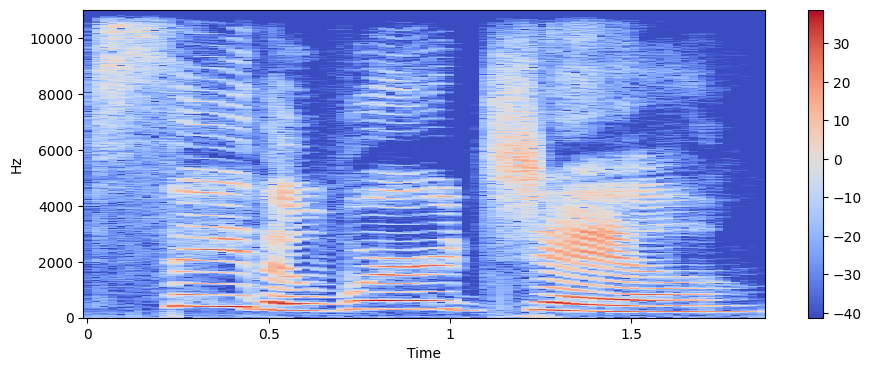

In [8]:
analyze_emotion("happy.wav",df)

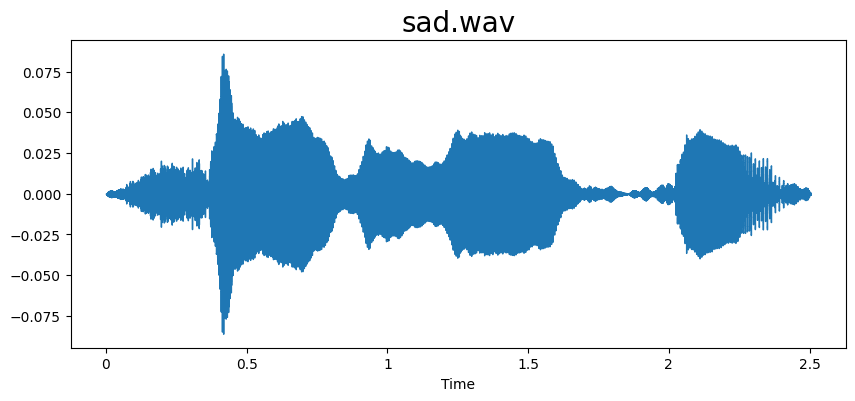

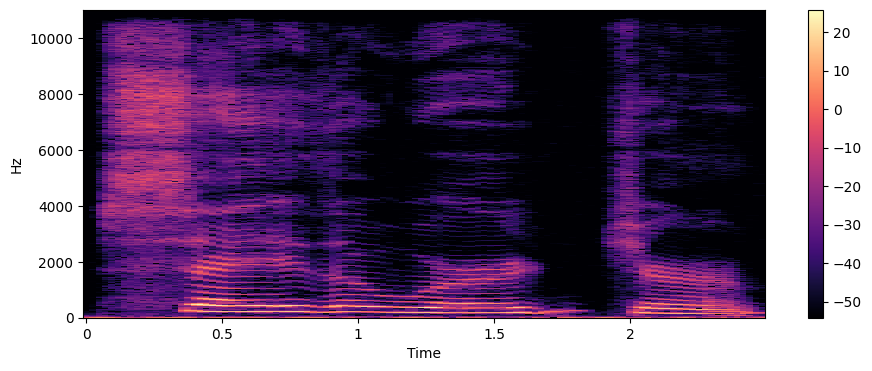

In [9]:
analyze_emotion("sad.wav",df)

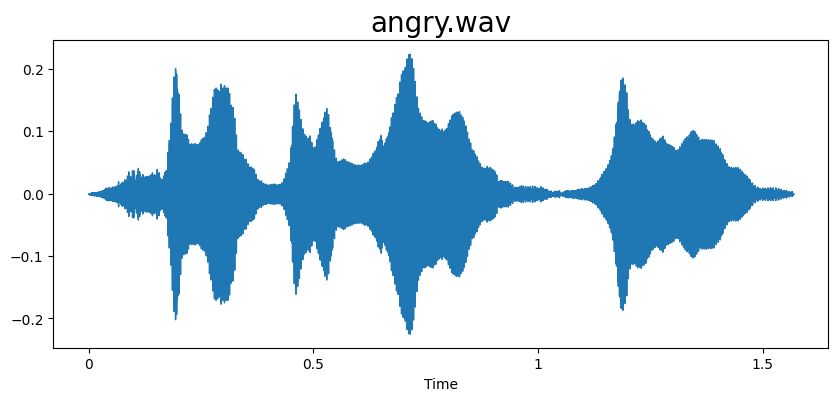

None

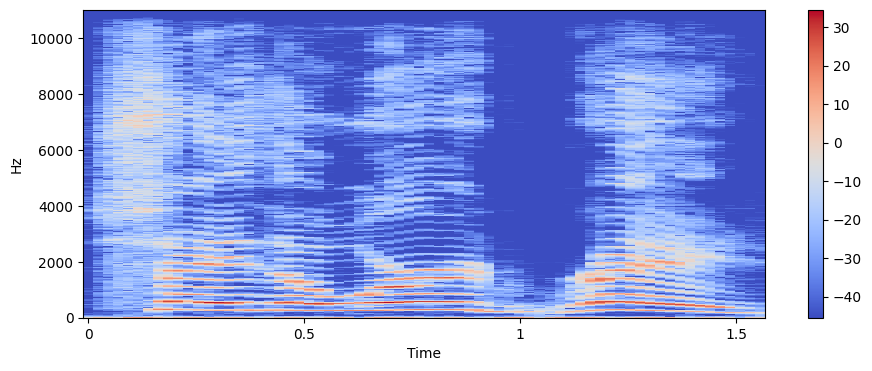

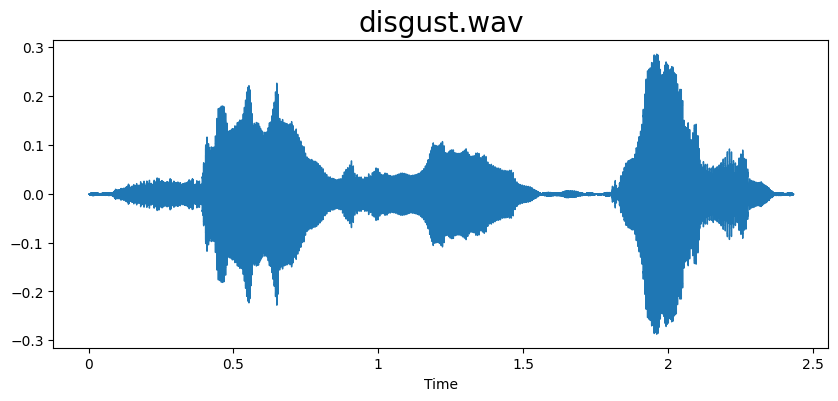

None

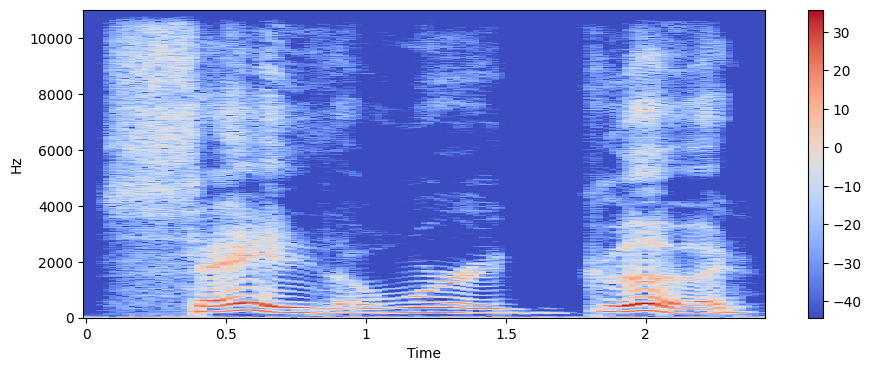

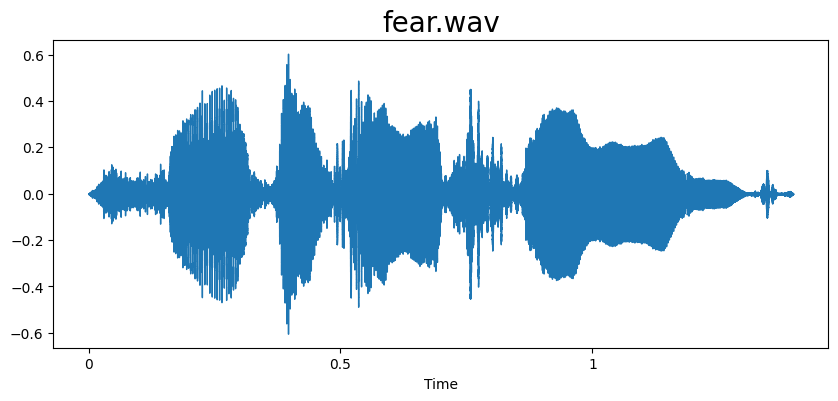

None

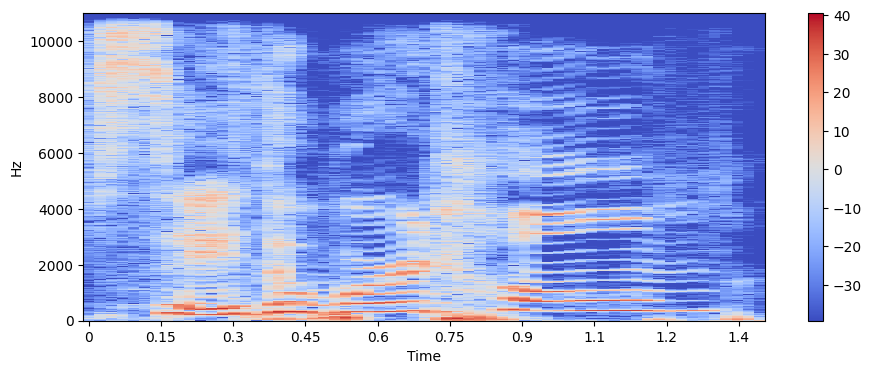

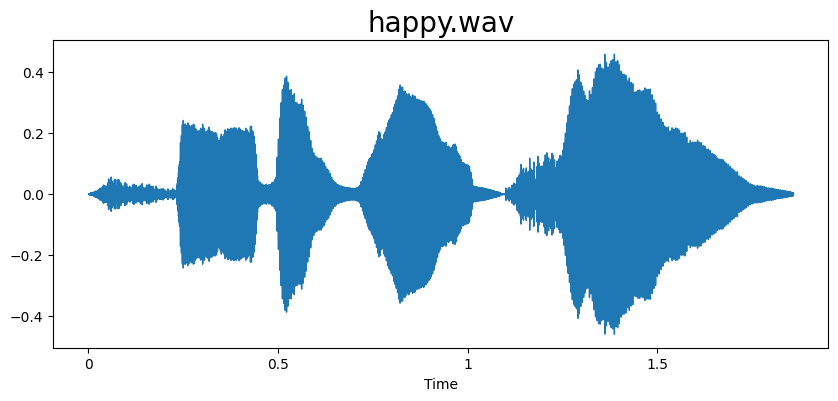

None

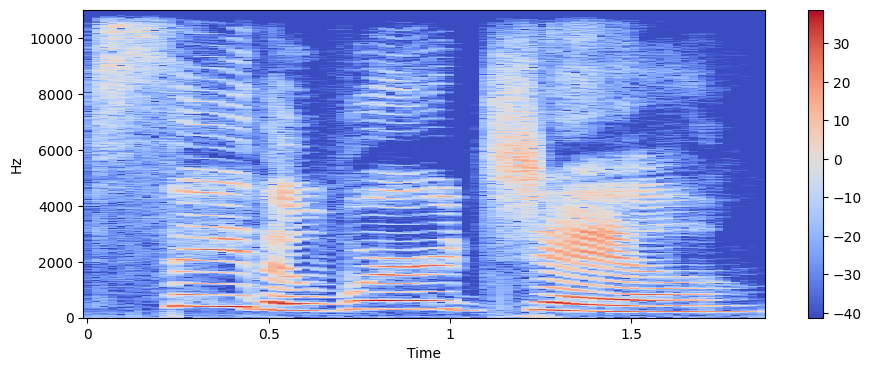

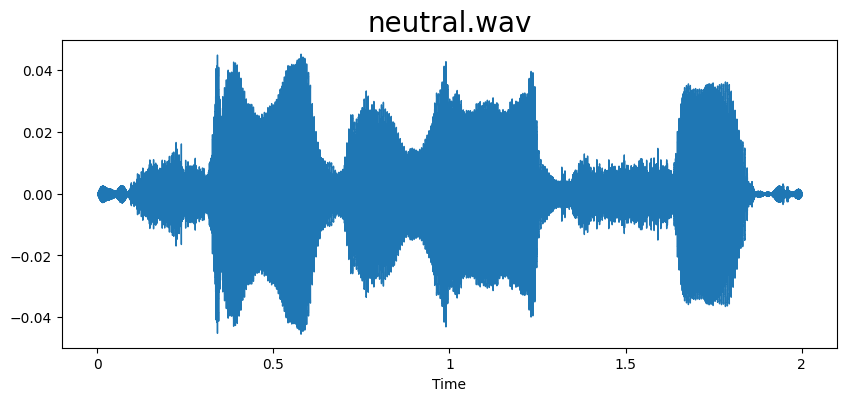

None

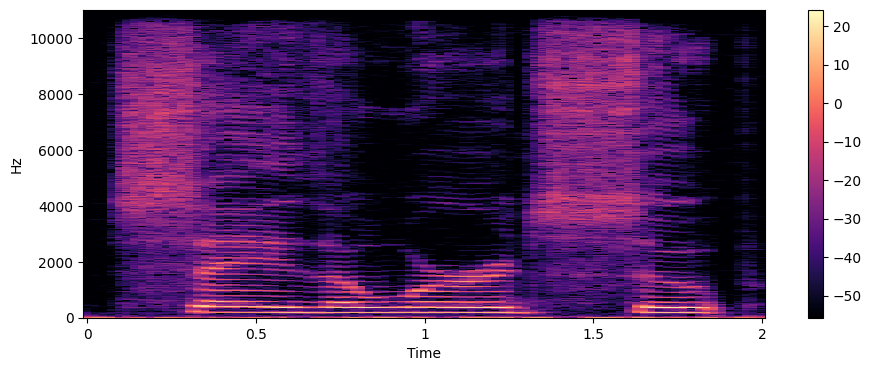

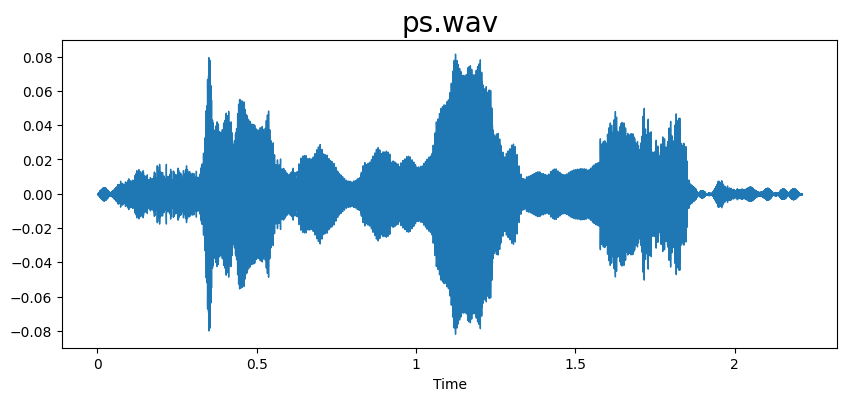

None

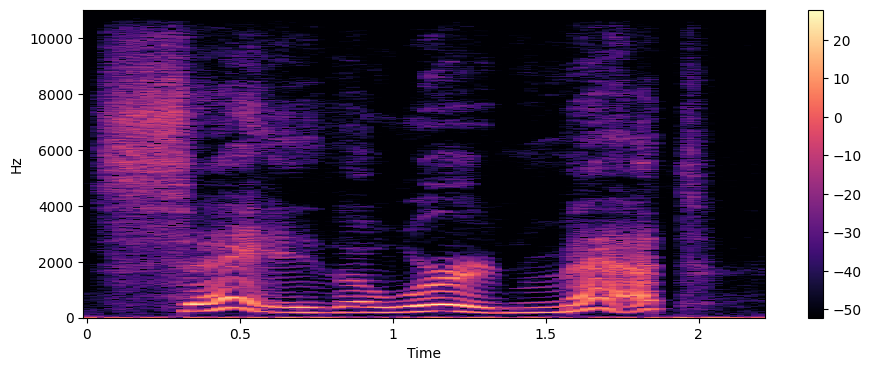

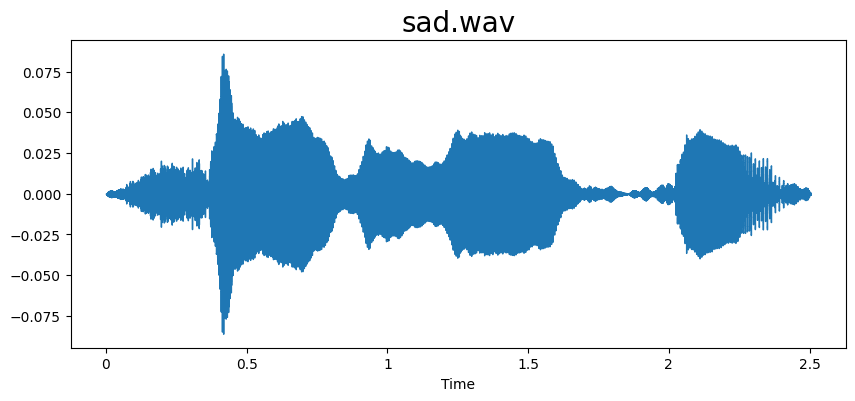

None

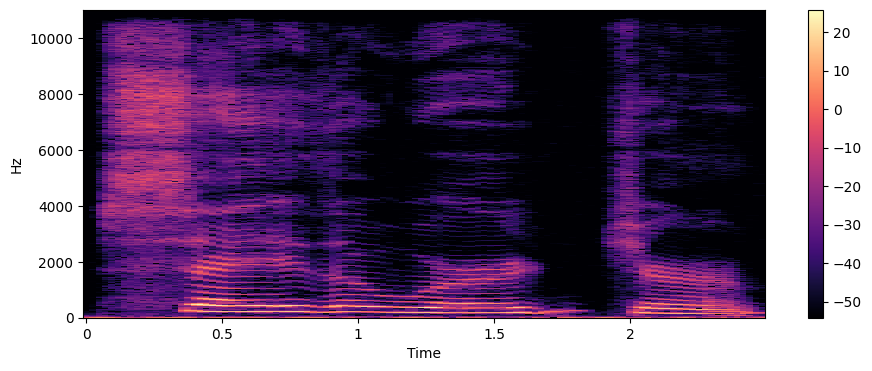

In [10]:
labels = ['angry.wav', 'disgust.wav', 'fear.wav', 'happy.wav', 'neutral.wav', 'ps.wav', 'sad.wav']

for i in range(len(labels)):
    display(analyze_emotion(labels[i], df))

In [11]:
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= df['speech'].apply(lambda x:MFCC(x))

X=[x for x in mfcc]
X=np.array(X)
X.shape
X=np.expand_dims(X,-1)
X.shape

print("New shape of X:", X.shape)


New shape of X: (5600, 40, 1)


In [12]:
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']])
y= y.toarray()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .25)


In [14]:
X.shape[0]

5600

In [15]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 0.9
    if epoch < 10:
        return initial_learning_rate
    else:
        return initial_learning_rate * tf.math.exp(-(epoch - 10) / decay_steps * decay_rate)

In [16]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.AdamW()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Define a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)

# Define LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Add all the callbacks to the list of callbacks when fitting the model
callbacks = [early_stopping, checkpoint, lr_scheduler]

# Print model summary
model.summary()

# Define a ModelCheckpoint callback to save the best model



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [17]:
history = model.fit(x_train, y_train, epochs=20, callbacks=callbacks)

Epoch 1/20
132/132 [==============================] - 6s 7ms/step - loss: 2.7664 - accuracy: 0.1488 - lr: 0.1000
Epoch 2/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9589 - accuracy: 0.1443 - lr: 0.1000
Epoch 3/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9559 - accuracy: 0.1433 - lr: 0.1000
Epoch 4/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9547 - accuracy: 0.1455 - lr: 0.1000
Epoch 5/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9527 - accuracy: 0.1514 - lr: 0.1000
Epoch 6/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9560 - accuracy: 0.1369 - lr: 0.1000
Epoch 7/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9550 - accuracy: 0.1381 - lr: 0.1000
Epoch 8/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9543 - accuracy: 0.1576 - lr: 0.1000
Epoch 9/20
132/132 [==============================] - 1s 7ms/step - loss: 1.9568 - accuracy: 0.1

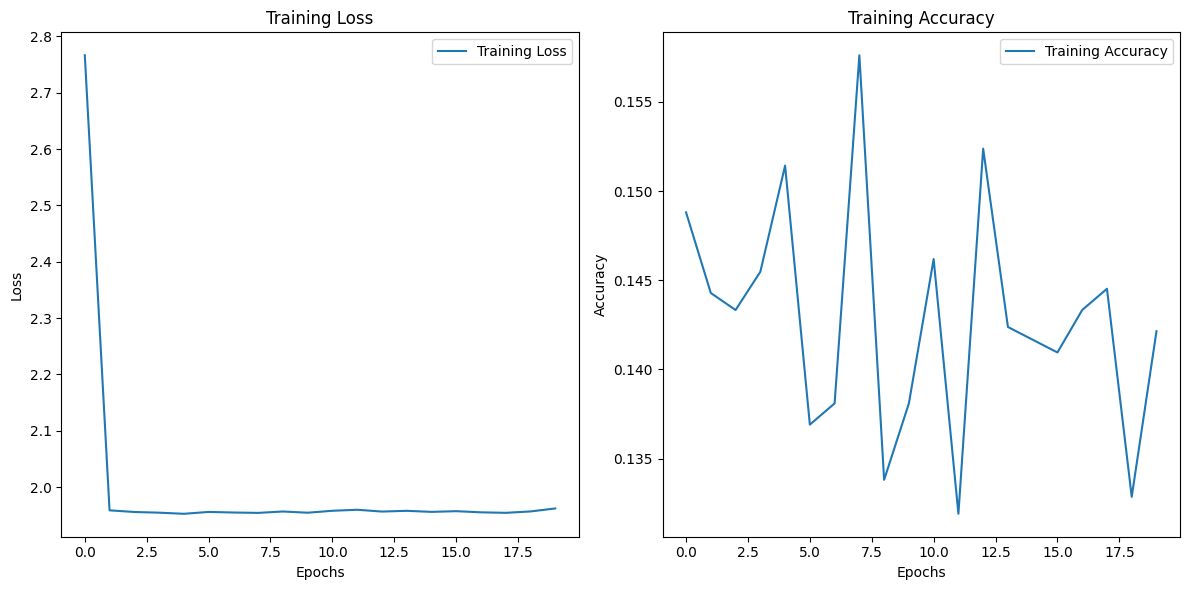

In [18]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Plot the training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
predictions = model.predict(x_test)

# If your predictions are one-hot encoded, you can convert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_labels)

print(f"Accuracy on test data: {accuracy * 100:.2f}%")


44/44 [==============================] - 1s 3ms/step
Accuracy on test data: 14.79%


In [20]:
sample_to_predict = x_test[5] 

sample_to_predict = sample_to_predict.reshape(1, sample_to_predict.shape[0], sample_to_predict.shape[1])

prediction = model.predict(sample_to_predict)

# If your predictions are one-hot encoded, you can convert them to class labels
predicted_label = np.argmax(prediction, axis=1)

print(f"Predicted label for sample x_test[5]: {predicted_label[0]}")


1/1 [==============================] - 0s 21ms/step
Predicted label for sample x_test[5]: 5


In [21]:
i = 20
predict__ = x_test[i]

predict__ = predict__.reshape(1, predict__.shape[0], predict__.shape[1])

prediction = model.predict(predict__)

predicted_label = prediction
predicted_label_original = encoder.inverse_transform(predicted_label)

print(f"Predicted for sample x_test {i}: {predicted_label_original[0][0]}")


1/1 [==============================] - 0s 19ms/step
Predicted for sample x_test 20: ps.wav


In [22]:
xx = y_test[20]
yy = encoder.inverse_transform(xx.reshape(1, -1))
yy

array([['neutral.wav']], dtype=object)

In [23]:
x_test[5]

array([[-3.0738763e+02],
       [ 6.0074417e+01],
       [-7.2030778e+00],
       [-4.9157763e+00],
       [-3.6610443e+01],
       [ 6.0108552e+00],
       [-3.5052128e+00],
       [-2.4804283e+01],
       [-2.8324006e+00],
       [-2.3479602e+00],
       [-1.6211454e+01],
       [ 8.3520088e+00],
       [-1.0090756e+01],
       [ 5.6196475e+00],
       [-3.5338976e+00],
       [-5.1717696e+00],
       [-3.9829702e+00],
       [-2.5143831e+00],
       [-1.3043797e+01],
       [ 5.7472193e-01],
       [-1.0297966e+01],
       [-2.0034235e+00],
       [-5.5236979e+00],
       [-1.5062793e+00],
       [ 1.0101819e+00],
       [ 4.7226138e+00],
       [ 3.3943710e+00],
       [ 8.6965055e+00],
       [ 1.2888376e+01],
       [ 9.3609819e+00],
       [ 1.3811159e+01],
       [ 7.9223509e+00],
       [ 2.1483839e-01],
       [ 3.0889759e+00],
       [-1.4938986e-01],
       [ 4.5667052e+00],
       [ 5.9477043e+00],
       [ 4.8906535e-01],
       [-2.3232303e+00],
       [-2.6964238e-01]],

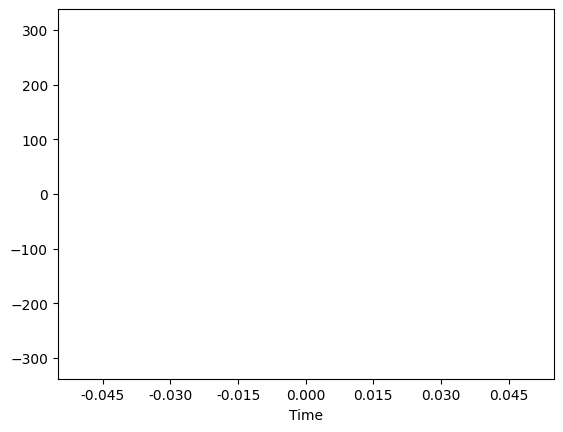

In [24]:
librosa.display.waveshow(x_test[5], sr=0.2)

In [25]:
import os

notebook_path = os.getcwd()
print("Notebook Path:", notebook_path)




Notebook Path: /kaggle/working
